In [83]:
import tensorflow as tf
import gym
from matplotlib import pyplot as plt
import numpy as np

In [2]:
env = gym.make('MsPacman-v0')
env

<TimeLimit<AtariEnv<MsPacman-v0>>>

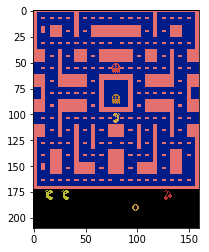

In [3]:
s = env.reset()
a = env.action_space.sample()
s_next, r, done, info = env.step(a)
env.close()

plt.imshow(s)

ep=1, t=1, T=1, avg_r=0.0


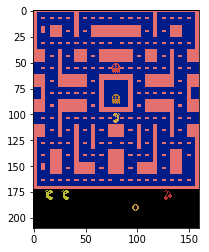

ep=1, t=2, T=2, avg_r=0.0


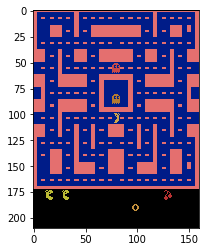

ep=1, t=4, T=4, avg_r=0.0


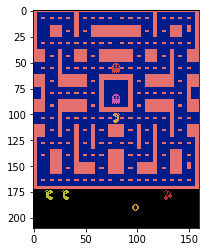

ep=1, t=8, T=8, avg_r=0.0


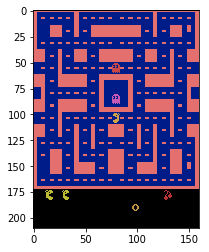

ep=1, t=16, T=16, avg_r=0.0


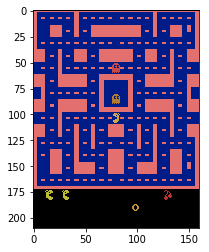

ep=1, t=32, T=32, avg_r=0.0


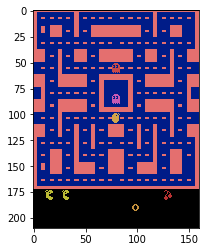

ep=1, t=64, T=64, avg_r=0.0


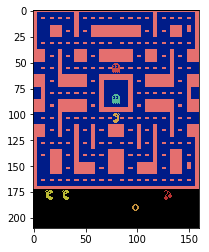

ep=1, t=128, T=128, avg_r=0.234375


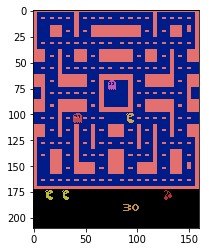

ep=1, t=256, T=256, avg_r=0.15625


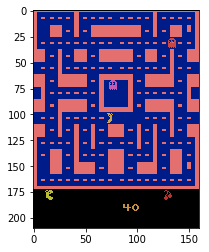

ep=1, t=512, T=512, avg_r=0.3125


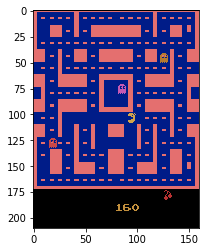

ep=2, t=398, T=1024, avg_r=0.322265625


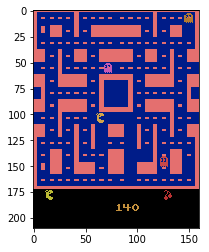

ep=4, t=26, T=2048, avg_r=0.29296875


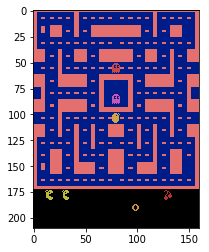

ep=7, t=79, T=4096, avg_r=0.28076171875


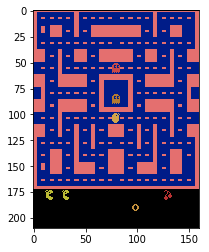

In [ ]:
from keras_gym.utils import reload_all
reload_all()

from keras_gym.utils import ExperienceCache
from keras_gym.utils.atari import AtariPreprocessor
from keras_gym.value_functions.predefined.atari import AtariDQN
from keras_gym.policies import ValueBasedPolicy
from keras_gym.algorithms import QLearning

Q = AtariDQN(env, target_model_sync_period=100, target_model_sync_tau=0.1)
policy = ValueBasedPolicy(Q, boltzmann_temperature=0.1)
algo = QLearning(Q, gamma=0.99, experience_cache_size=100000, experience_replay_batch_size=32)

T = 0
G = 0.0
for ep in range(1, 1 + 1000):
    s = env.reset()
    for t in range(1, 1 + env._max_episode_steps):
        a = policy.epsilon_greedy(s, epsilon=np.clip(1 - T / 100000., 0.1, 1.0))
        s_next, r, done, info = env.step(a)

        # global counters
        T += 1
        G += r

        if np.log2(T).is_integer():
            print(f"ep={ep}, t={t}, T={T}, avg_r={G/T}")
            plt.imshow(s)
            plt.show()
        
        if T > 1024:
            algo.update(s, a, r, s_next, done)
        
        if done:
            break
            
        s = s_next

In [77]:
Q.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 33600)             0         
_________________________________________________________________
reshape_and_rescale (Lambda) (None, 105, 80, 4)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 25, 19, 16)        4112      
_________________________________________________________________
conv2 (Conv2D)               (None, 11, 8, 32)         8224      
_________________________________________________________________
flatten (Flatten)            (None, 2816)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               360576    
_________________________________________________________________
outputs (Dense)              (None, 9)                 1161      
Total para

In [22]:
X.shape

(1, 4, 105, 80)